In [1]:
# ESSENTIAL
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
import random
import os
from datetime import datetime

# CUSTOM
from wrappers import bitfinex as bfx
from wrappers import technical_analysis as ta
from wrappers import modeling as mdl

# UNIVERSAL PORTFOLIO
# http://nbviewer.jupyter.org/github/paulperry/quant/blob/master/OLPS_Comparison.ipynb
import six
import universal as up                # PACKAGE
from universal import tools # LOCAL
from universal import algos # LOCAL
import logging

# ML / RL
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gym
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from keras.optimizers import Adam

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['lines.linewidth'] = 1
default_color_cycle = mpl.rcParams['axes.color_cycle']

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Classes

In [2]:
class Agent():
    
    def __init__(self, state_size, action_size, n_assets):
        self.weight_backup = 'trader_agent_weights.h5'
        self.state_size = state_size
        self.action_size = action_size
        self.n_assets = n_assets
        self.memory = deque(maxlen = 2000) # deque is a list that appends one one side and pops out items on other when len is reached
        self.learning_rate = 0.001         # init learning rate too low?
        self.gamma = 0.95                  # might want to change this / test different values
        self.exploration_rate = 1.0
        self.exploration_min = 0.25        # another one to test, should exploration rate remain high? was orig 1%
        self.exploration_decay = 0.995     # another to test
        self.brain = self._build_model()
    
    # neural net for Deep-Q Learning model
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation = 'relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.action_size, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        
        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        
        return model
    
    def save_model(self):
        self.brain.save(self.weight_backup)
    
    '''
    DEFINITELY: THIS NEEDS TO BE EDITED SO THAT IT RETURNS THE WEIGHTS RATHER THAN AN ACTION.
    
    IT SHOULD BE PRETTY EASY: FOR EXPLORE, JUST RANDOMLY ASSIGN WEIGHTS TO THE n ASSETS
    UNTIL IT IS 1
    '''
    def act(self, state):
        
        # explore: if lower than epsilon, return a random set of weights (adding up to 1, obv)
        if np.random.rand() <= self.exploration_rate:
            random_weights = np.array([np.random.rand() for _ in range(self.n_assets)])
            random_weights = random_weights / sum(random_weights)
            return random_weights
        
        # exploit: this predicts the future reward for the current state
        predicted_reward = self.brain.predict(state)
        predicted_weights = predicted_reward / sum(predicted_reward)#      <<<< THIS HAS NOT BEEN TESTED OR CONFIRMED
        
        return predicted_weights
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    '''
    I DON'T THINK THIS MAKES SENSE, I CAN KEEP THE LOG RETURN PART, BUT AVG RETURNS ONLY MAKES SENSE
    WHEN I HAVE A SINGLE VALUE PER EPISODE (IS THAT WHAT I NEED?). WHAT I THINK THIS NEEDS TO BE IS THE
    RETURN FOR A SINGLE ASSET. THAT CAN THEN BE USED TO CREATE THE WEIGHTS.
    
    # the reward function, average logarithmic return
    def reward(self, weights, delta):
        ln_returns = np.log(weights * delta)
        avg_log_return = sum(ln_returns) / len(ln_returns)
        return avg_log_return
    '''
    
    def replay(self, sample_batch_size):
        
        # make sure memory is at least the sample size
        if len(self.memory) < sample_batch_size:
            return
        
        # get a sample from the memory. this is a small sample of previous state, action,
        # rewards, and next states this sample will be used to train the neural net.
        sample_batch = random.sample(self.memory, sample_batch_size)
        
        # this loops through each sample from our "memory"
        for state, action, reward, next_state, done in sample_batch:
            
            # i'm not sure why this is here, but it sets the target
            # as the reward (1) when for when the episode is done
            target = reward
            
            # if the sample is not the end of an episode (and therefore has a "next state")
            # then calculate the "target" component of the loss function for Q Learning
            if not done:
                
                '''
                I NEED TO FIGURE OUT HOW TO:
                    - INCORPORATE THE REWARD FUNCTION
                    - MAKE SURE THAT THERE IS A PROCESS / INCENTIVE FOR GETTING AN INCREASED REWARD
                
                IN MAXIMIZING THE REWARD. THERE ARE TWO OPTIONS:
                    - JUST PICKING THE STRONGEST PERFORMER OF THE PERIOD (THAT WOULD BE TRULY MAXIMIZING RETURN)
                    - MAXIMIZING A RISK-ADJUSTED MEASURE OF RETURN. FOR INSTANCE, THE SHARPE RATIO. THIS ONE IS A
                      A LITTLE MORE COMPLICATED SO I'LL TRY THE PICK THE WINNER STRATEGY FIRST AND THEN TRY THIS.
                '''
                
                # the "target" component is representation of the future discounted reward of a
                # correct action. in the Q loss function we'll subtract our prediction from this.
                # if we also made a correct action for `the current state, then the difference
                # (loss) will be low. the neural net is trying to minimize this and will
                # eventually learn what the best action is given the state in order to earn
                # the most reward.
                target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
                print('Target:', target)
            
            ### SUMMARY
            # make the agent approximately map the current state to the future 
            # discounted reward. this will be called target_f
            
            ### DETAIL 1
            # first, get the predicted future reward from the current state. this is what our model,
            # or brain, currently thinks the reward will be
            target_f = self.brain.predict(state)
            
            ### DETAIL 2
            # now, since we need to replace the respective action with the target, which again, is
            # the future discounted reward. this target_f will be the target when fitting the net.
            target_f[0][action] = target
            
            ### DETAIL 3
            # fit the model so that the current state is mapped to the future reward for each action
            self.brain.fit(state, target_f, epochs = 1, verbose = 0)
        
        # reduce the exploratin rate with the appropriate decay rate
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

# Functions

In [3]:
def get_trade_history_from_date(cp, _from):
    
    # connect to db
    conn = sqlite3.connect('db/crypto.db')
    
    # get trade history per currency pair and date specified
    get_data_query = '''
    
    SELECT date, currency_pair, rate, amount
    FROM trade_history
    WHERE currency_pair="%s"
    AND date >= %s;
    
    ''' % (cp, _from)
    
    # read into df and close connection
    df = pd.read_sql(get_data_query, conn)
    conn.close()
    
    return df

# parse out performance summary from portfolio object
def olps_stats(df):
    
    for name, r in df.results.iteritems():
        df.ix[name,'profit'] = r.profit_factor
        df.ix[name,'sharpe'] = r.sharpe
        df.ix[name,'information'] = r.information
        df.ix[name,'annualized_return'] = r.annualized_return * 100
        df.ix[name,'drawdown_period'] = r.drawdown_period
        df.ix[name,'winning_pct'] = r.winning_pct * 100
    
    return df

## Get Trade History

In [5]:
'''
NEW PAIR
'''
bfx_currencies = {
    
    'USDT_REP': 'tREPUSD',
    'USDT_ELF': 'tELFUSD',
    'USDT_TRX': 'tTRXUSD',
    'USDT_RCN': 'tRCNUSD',
    'USDT_SNG': 'tSNGUSD',
    'USDT_RLC': 'tRLCUSD',
    'USDT_AID': 'tAIDUSD'
}

aug1 = 1501545600

xdf = pd.DataFrame()

for k in bfx_currencies:
    
    print('\n\nstarting', k)
    
    # get full history
    df = bfx.get_full_trade_history(bfx_currencies[k], aug1)
    
    # process the raw data
    df = bfx.process_raw_bfx_trade_history(df)
    df = df.sort_values('date', ascending = True)
    df['currency_pair'] = k
    
    xdf = xdf.append(df)
    
    # add to db
    #bfx.update_trade_history(df)
    
    #del df
    

# '''
# ALREADY HAVE COIN IN DB
# '''

# currency_pairs = [
#     'USDT_BTC', 'USDT_BCH', 'USDT_LTC',
#     'USDT_ETH', 'USDT_ETC', 'USDT_ZEC',
#     'USDT_XMR', 'USDT_DASH', 'USDT_SAN',
#     'USDT_NEO', 'USDT_IOTA', 'USDT_OMG',
#     'USDT_QTUM'
# ]

# '''
# ALL AT SAME TIME (OFTEN BUGGY)
# '''
# # # get the latest trades and add to db
# # df = bfx.get_latest_bfx_trade_history(currency_pairs)
# # bfx.update_trade_history(df)

# # # free memory
# # del df

# '''
# ONE AT A TIME :)
# '''
# # get latest trades for each currency pair
# for cp in currency_pairs:
    
#     # get the latest trades and add to db
#     df = bfx.get_latest_bfx_trade_history([cp])
#     bfx.update_trade_history(df)



starting USDT_ELF

Iteration: 10
Status: 2018-01-31 04:48:20.916000
Concentration: 1 days 02:19:15.007000

Iteration: 20
Status: 2018-01-30 03:51:43.433000
Concentration: 1 days 00:56:37.483000
<urlopen error [Errno 8] nodename nor servname provided, or not known>

Iteration: 20
Status: 2018-01-30 03:51:43.433000
Concentration: 0 days 00:00:00

Iteration: 30
Status: 2018-01-28 23:24:18.309000
Concentration: 1 days 04:27:25.124000

Iteration: 40
Status: 2018-01-27 19:15:25.849000
Concentration: 1 days 04:08:52.460000

Iteration: 50
Status: 2018-01-26 14:09:21.485000
Concentration: 1 days 05:06:04.364000
HTTP Error 500: Internal Server Error

Iteration: 60
Status: 2018-01-25 16:21:19.890000
Concentration: 0 days 21:48:01.595000


/Users/zach-eberhart/Desktop/crypto/wrappers/bitfinex.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raw_trade_history_df['date'] = raw_trade_history_df['date'] / 1000
/Users/zach-eberhart/Desktop/crypto/wrappers/bitfinex.py:492: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raw_trade_history_df['date'] = raw_trade_history_df['date'].astype('int')




starting USDT_RLC


starting USDT_TRX

Iteration: 10
Status: 2018-01-29 11:36:55.133000
Concentration: 2 days 19:30:40.790000

Iteration: 20
Status: 2018-01-26 16:05:12.089000
Concentration: 2 days 19:31:43.044000

Iteration: 30
Status: 2018-01-24 23:29:11.554000
Concentration: 1 days 16:36:00.535000


starting USDT_REP


starting USDT_AID


starting USDT_SNG


starting USDT_RCN


In [8]:
#xdf.to_csv('new_pairs_2018-02-01.csv')

In [4]:
# set candle length
time_periods = [
    #'30min',
    #'1H',
    #'4H',
    #'6H',
    '12H'
    #'24H'
]

# primary currency pairs to get trade history for
currency_pairs = [
    'USDT_BTC', 'USDT_BCH', 'USDT_LTC',
    'USDT_ETH', 'USDT_ETC', 'USDT_ZEC',
    'USDT_XMR', 'USDT_DASH', 'USDT_SAN',
    'USDT_NEO', 'USDT_IOTA', 'USDT_OMG',
    'USDT_QTUM'
]

# loop through each time period and write to csv
for per in time_periods:
    
    # set empty dataframe for appending
    xdf = pd.DataFrame()
    
    # loop through each cp and get the data for the specified time period
    for cp in currency_pairs:

        # and go!
        print('starting', cp)
        df = ta.get_all_attributes(cp, per)

        # classify charts with their respective cp and append to master df
        df['currency_pair'] = cp
        xdf = xdf.append(df)
        print()
    
    # write to csv
    _filename = 'portfolio_export_all_features_%s_2018-01-03.csv' % per
    xdf.to_csv(_filename)
    
    # free memory
    del xdf
    
    mdl.send_text_message('Finished processing %s' % per)
    print('finished %s' % per)

starting USDT_BTC


NameError: name 'ta' is not defined

# Get Data

In [4]:
# ALL PROTOCOL
currency_pairs = [
    'USDT_BTC', 'USDT_BCH', 'USDT_LTC',
    'USDT_ETH', 'USDT_ETC', 'USDT_ZEC',
    'USDT_XMR', 'USDT_DASH', 'USDT_SAN',
    'USDT_NEO', 'USDT_IOTA', 'USDT_OMG',
    'USDT_QTUM'
]

xdf_1min = pd.DataFrame()
xdf_5min = pd.DataFrame()
xdf_15min = pd.DataFrame()
xdf_30min = pd.DataFrame()
xdf_1hr = pd.DataFrame()
xdf_2hr = pd.DataFrame()
xdf_4hr = pd.DataFrame()
xdf_6hr = pd.DataFrame()
xdf_12hr = pd.DataFrame()
xdf_24hr = pd.DataFrame()

for cp in currency_pairs:
    
    print('\n\nStarting:', cp, '\n')
    
    # get all trades from 2017
    df = get_trade_history_from_date(cp, 1483228800)
    
    # 1 MINUTES
    df_1min = ta.get_ticks_from_df(df, '1min')
    df_1min['currency_pair'] = cp
    xdf_1min = xdf_1min.append(df_1min)
    del df_1min
    print('Finished 1 minute periods...')
    
    # 5 MINUTES
    df_5min = ta.get_ticks_from_df(df, '5min')
    df_5min['currency_pair'] = cp
    xdf_5min = xdf_5min.append(df_5min)
    del df_5min
    print('Finished 5 minute periods...')
    
    # 15 MINUTES
    df_15min = ta.get_ticks_from_df(df, '15min')
    df_15min['currency_pair'] = cp
    xdf_15min = xdf_15min.append(df_15min)
    del df_15min
    print('Finished 15 minute periods...')
    
    # 30 MINUTES
    df_30min = ta.get_ticks_from_df(df, '30min')
    df_30min['currency_pair'] = cp
    xdf_30min = xdf_30min.append(df_30min)
    del df_30min
    print('Finished 30 minute periods...')

    # 1 HOURS
    df_1hr = ta.get_ticks_from_df(df, '1H')
    df_1hr['currency_pair'] = cp
    xdf_1hr = xdf_1hr.append(df_1hr)
    del df_1hr
    print('Finished 1 hour periods...')
    
    # 2 HOURS
    df_2hr = ta.get_ticks_from_df(df, '2H')
    df_2hr['currency_pair'] = cp
    xdf_2hr = xdf_2hr.append(df_2hr)
    del df_2hr
    print('Finished 2 hour periods...')
    
    # 4 HOURS
    df_4hr = ta.get_ticks_from_df(df, '4H')
    df_4hr['currency_pair'] = cp
    xdf_4hr = xdf_4hr.append(df_4hr)
    del df_4hr
    print('Finished 4 hour periods...')
    
    # 6 HOURS
    df_6hr = ta.get_ticks_from_df(df, '6H')
    df_6hr['currency_pair'] = cp
    xdf_6hr = xdf_6hr.append(df_6hr)
    del df_6hr
    print('Finished 6 hour periods...')
    
    # 12 HOURS
    df_12hr = ta.get_ticks_from_df(df, '12H')
    df_12hr['currency_pair'] = cp
    xdf_12hr = xdf_12hr.append(df_12hr)
    del df_12hr
    print('Finished 12 hour periods...')
    
    # 24 HOURS
    df_24hr = ta.get_ticks_from_df(df, '24H')
    df_24hr['currency_pair'] = cp
    xdf_24hr = xdf_24hr.append(df_24hr)
    del df_24hr
    print('Finished 24 hour periods...')
    
    del df



Starting: USDT_BTC 

converting to OHLC
Some NaN values are found, scrubbing out.
Finished 1 minute periods...
converting to OHLC
Some NaN values are found, scrubbing out.
Finished 5 minute periods...
converting to OHLC
Finished 15 minute periods...
converting to OHLC
Finished 30 minute periods...
converting to OHLC
Finished 1 hour periods...
converting to OHLC
Finished 2 hour periods...
converting to OHLC
Finished 4 hour periods...
converting to OHLC
Finished 6 hour periods...
converting to OHLC
Finished 12 hour periods...
converting to OHLC
Finished 24 hour periods...


Starting: USDT_BCH 

converting to OHLC
Some NaN values are found, scrubbing out.
Finished 1 minute periods...
converting to OHLC
Some NaN values are found, scrubbing out.
Finished 5 minute periods...
converting to OHLC
Some NaN values are found, scrubbing out.
Finished 15 minute periods...
converting to OHLC
Some NaN values are found, scrubbing out.
Finished 30 minute periods...
converting to OHLC
Finished 1 hour p

Finished 4 hour periods...
converting to OHLC
Finished 6 hour periods...
converting to OHLC
Finished 12 hour periods...
converting to OHLC
Finished 24 hour periods...


Starting: USDT_QTUM 

converting to OHLC
Some NaN values are found, scrubbing out.
Finished 1 minute periods...
converting to OHLC
Some NaN values are found, scrubbing out.
Finished 5 minute periods...
converting to OHLC
Some NaN values are found, scrubbing out.
Finished 15 minute periods...
converting to OHLC
Some NaN values are found, scrubbing out.
Finished 30 minute periods...
converting to OHLC
Finished 1 hour periods...
converting to OHLC
Finished 2 hour periods...
converting to OHLC
Finished 4 hour periods...
converting to OHLC
Finished 6 hour periods...
converting to OHLC
Finished 12 hour periods...
converting to OHLC
Finished 24 hour periods...


In [5]:
# CSV BACKUP
# xdf_1min.to_csv('2017_export_1min.csv')
# xdf_5min.to_csv('2017_export_5min.csv')
# xdf_15min.to_csv('2017_export_15min.csv')
# xdf_30min.to_csv('2017_export_30min.csv')
# xdf_1hr.to_csv('2017_export_1hr.csv')
# xdf_2hr.to_csv('2017_export_2hr.csv')
# xdf_4hr.to_csv('2017_export_4hr.csv')
# xdf_6hr.to_csv('2017_export_6hr.csv')
# xdf_12hr.to_csv('2017_export_12hr.csv')
# xdf_24hr.to_csv('2017_export_24hr.csv')

# IMPORT BACKUP
#df = pd.read_csv('portfolio_optim_data_export_24hr.csv')
#df.index = pd.to_datetime(df['date'])
#df = df.drop('date', 1)

# Transform Data

In [4]:
currency_pairs = ['USDT_ETH', 'USDT_BTC', 'USDT_LTC', 'USDT_ZEC', 'USDT_XMR', 'USDT_DASH', 'USDT_ETC']

In [5]:
print('shape:', df.shape)
df.head()

shape: (2211, 8)


,open,high,low,close,volume,mean_trade_price,median_trade_price,currency_pair
date,,,,,,,,
2017-01-01,7.980000,8.5868,7.98,8.124237,64696.874030,8.302818,8.300000,USDT_ETH
2017-01-02,8.124237,8.5000,8.10,8.345185,50612.404033,8.261607,8.214978,USDT_ETH
2017-01-03,8.370000,9.9500,8.30,9.661000,247188.321563,9.276042,9.450000,USDT_ETH
2017-01-04,9.730000,11.1500,9.40,10.849999,234768.127621,10.540372,10.679000,USDT_ETH
2017-01-05,10.849999,11.7000,9.20,10.294000,343635.622281,10.375378,10.264000,USDT_ETH


In [6]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (7533, 42)


In [7]:
xdf.head()

,usdteth_open,usdteth_high,usdteth_low,usdteth_close,usdteth_volume,usdteth_mean_trade_price,usdteth_median_trade_price,usdtbtc_open,usdtbtc_high,usdtbtc_low,...,usdtxmr_volume,usdtxmr_mean_trade_price,usdtxmr_median_trade_price,usdtdash_open,usdtdash_high,usdtdash_low,usdtdash_close,usdtdash_volume,usdtdash_mean_trade_price,usdtdash_median_trade_price
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,7.980000,8.2639,7.980000,8.008506,607.338241,8.099293,8.038314,966.610000,967.79,962.860000,...,4.356732,13.782764,13.780000,11.348855,11.350000,11.348855,11.350000,0.264597,11.349714,11.350000
2017-01-01 01:00:00,8.044822,8.2833,8.044822,8.229053,1388.866123,8.171762,8.198000,965.000001,967.25,961.700000,...,19.253046,13.740354,13.720153,11.326380,11.340000,11.305037,11.305037,0.354003,11.320567,11.326380
2017-01-01 02:00:00,8.216482,8.4889,8.213986,8.242144,1722.886782,8.307435,8.263400,964.133268,967.00,964.133268,...,8.660275,13.623455,13.590000,11.323686,11.340000,11.323686,11.340000,1.355384,11.338517,11.340000
2017-01-01 03:00:00,8.423000,8.5771,8.242144,8.393000,10087.695546,8.424250,8.439848,967.000000,968.00,961.700000,...,39.545869,13.566764,13.547028,11.340000,11.340000,11.305529,11.305529,0.287852,11.322764,11.322764
2017-01-01 04:00:00,8.393000,8.5868,8.393000,8.528042,4643.198210,8.498296,8.500000,963.840000,964.00,957.020000,...,73.222784,13.491745,13.500000,11.305037,11.305037,11.305037,11.305037,0.003303,11.305037,11.305037


# Universal Portfoflio Optimization
## (Scaled 1H)

In [12]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-1500,:].copy()
test = norm_prices[-1500:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (6033, 6)
Test Shape: (1500, 6)


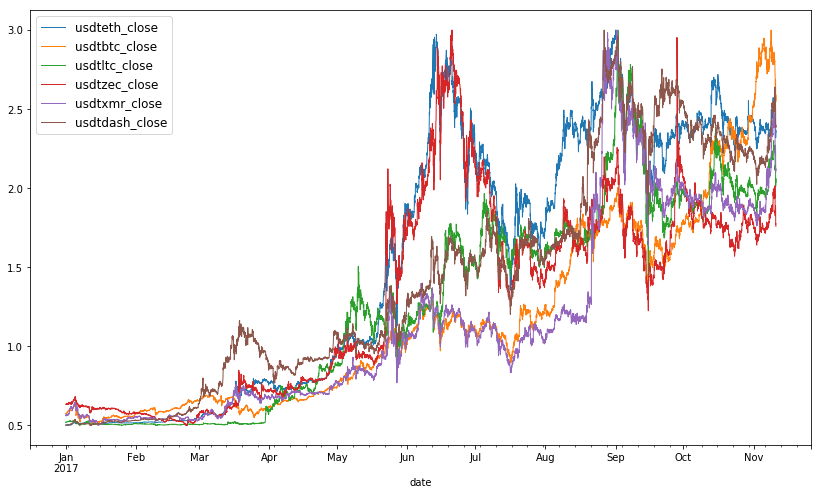

In [14]:
# plot scaled prices
pd.DataFrame(norm_prices,
             columns = price_df.columns.tolist(),
             index = price_df.index).plot(figsize = (14, 8));

In [15]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

In [33]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.15179,0.640627,0.209451,8.01765,1609,53.456
CRP,1.11964,0.502906,-0.129014,6.57848,1479,54.2019
BCRP,1.1178,0.526849,0.0377272,7.10022,1197,53.887
EG,1.1164,0.498174,-3.66266,6.50492,1479,54.0693
BAH,1.10281,0.443682,-0.52517,6.01709,1528,53.7378
Anticor,0.890027,-0.567501,-1.40446,-8.99862,5934,45.7576
Kelly,0.737291,-1.1751,-1.23926,-93.7018,6032,52.6492
OLMAR,0.691683,-1.78641,-3.22103,-27.6635,6030,37.4356
RMR,0.671273,-1.93722,-3.44582,-29.5449,6030,36.6207
PAMR,0.504792,-3.35522,-5.46769,-47.4889,6032,27.7142


## Run on Test

In [42]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.0786,0.411501,0.579925,6.0645,445,52.3682
CRP,1.00214,0.0103738,-0.141083,0.138934,750,50.2
EG,1.00102,0.00494683,-2.7264,0.0675641,983,50
BAH,0.999317,-0.00330545,-0.374458,-0.0454917,994,50.6667
ONS,0.997568,-0.0117857,-0.153219,-0.16409,1377,50.0667
Anticor,0.780477,-1.21999,-2.25465,-18.7035,1497,44.5412
Kelly,0.645256,-1.81483,-1.79412,-98.673,1499,50
OLMAR,0.564258,-2.75742,-4.60403,-38.9691,1497,36.8737
RMR,0.541474,-3.00277,-5.12302,-40.8371,1497,36.7401
CWMR,0.366602,-5.05651,-8.62635,-58.1819,1499,27.5333


# (Scaled 30Min)

In [ ]:
df = xdf_30min.copy()

In [11]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (15256, 49)


In [27]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-3000,:].copy()
test = norm_prices[-3000:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (12087, 7)
Test Shape: (3000, 7)


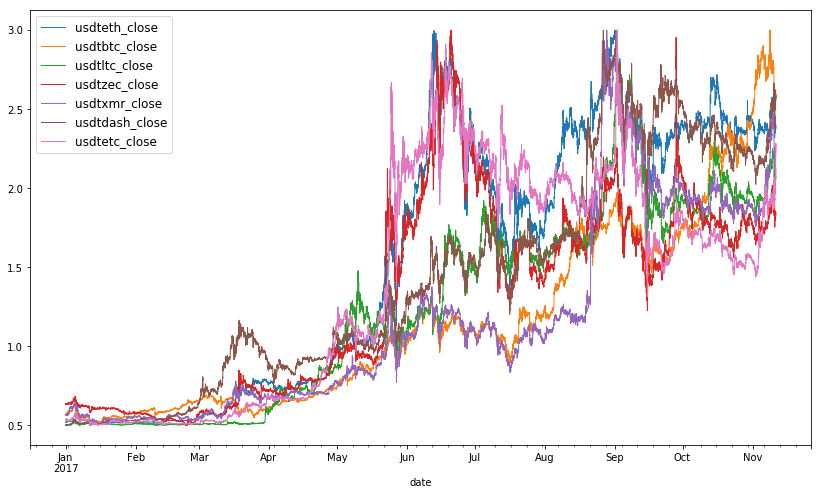

In [28]:
# plot scaled prices
pd.DataFrame(norm_prices,
             columns = price_df.columns.tolist(),
             index = price_df.index).plot(figsize = (14, 8));

In [14]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

In [30]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: invalid value encountered in log
  self.r_log = np.log(self.r)


,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.09794,0.436225,0.0780669,3.71167,3225,52.602
CRP,1.08246,0.353262,-0.126892,3.18706,2958,53.3879
BCRP,1.08044,0.364987,0.00759585,3.44211,2757,52.1182
EG,1.08038,0.353643,-3.71157,3.14508,2958,52.9081
BAH,1.07167,0.314823,-0.39827,2.93221,3056,52.8584
Anticor,0.783196,-1.18678,-2.01116,-14.1624,12032,42.7532
Kelly,0.730216,-1.12258,-1.17473,-84.1742,12086,51.566
OLMAR,0.555998,-2.88552,-4.45298,-32.8235,12083,32.8275
RMR,0.5454,-2.97835,-4.53113,-33.7143,12083,32.278
PAMR,0.366335,-5.25836,-7.72048,-51.584,12086,24.0811


In [31]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/cwmr.

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.05865,0.313582,0.35108,3.25446,882,51.4706
EG,1.01336,0.0661703,-2.75139,0.61485,1966,49.8
BAH,1.01279,0.0636331,-0.316062,0.595339,1989,49.9667
CRP,1.01213,0.0600028,-0.224902,0.550813,1500,50.5667
ONS,1.01031,0.0502582,-0.147932,0.481133,2758,49.7
Anticor,0.76287,-1.40175,-2.48953,-14.936,2994,43.6473
Kelly,0.616349,-2.09615,-2.07696,-96.3273,2999,47.322
OLMAR,0.408608,-4.47489,-7.59982,-42.4384,2994,31.4945
RMR,0.388814,-4.71904,-7.97881,-43.8983,2994,30.7281
CORN,0.270582,-6.64303,-7.19416,-52.3219,2994,20.5066


# (Scaled 2 Hours)

In [8]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (3814, 49)


In [10]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-750,:].copy()
test = norm_prices[-750:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (3022, 7)
Test Shape: (750, 7)


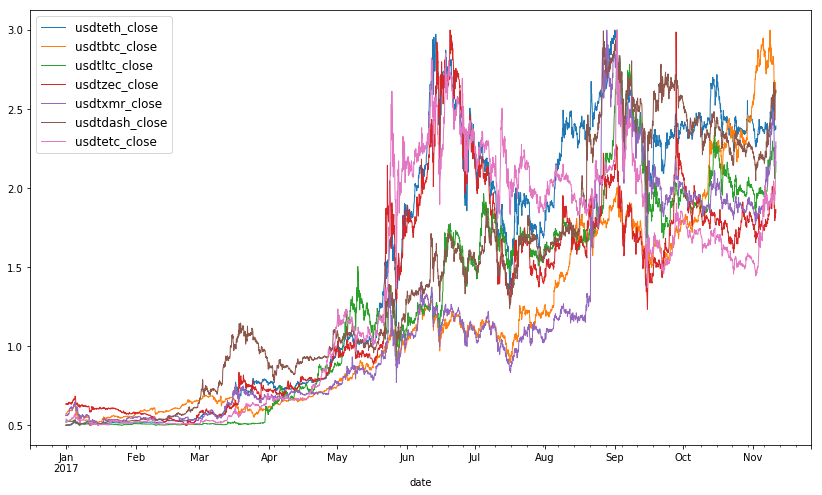

In [11]:
# plot scaled prices
pd.DataFrame(norm_prices,
             columns = price_df.columns.tolist(),
             index = price_df.index).plot(figsize = (14, 8));

In [13]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

In [13]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: invalid value encountered in log
  self.r_log = np.log(self.r)


,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.21606,0.893307,0.329458,16.4593,804,54.8312
BCRP,1.16857,0.738296,0.103749,14.7267,598,55.3276
CRP,1.16748,0.694693,-0.113012,13.5122,744,56.6181
EG,1.16169,0.683298,-3.76459,13.3242,745,55.5261
BAH,1.14366,0.611592,-0.670065,12.346,769,55.5923
Anticor,0.985623,-0.0694247,-0.963193,-1.58731,1839,47.6729
OLMAR,0.802559,-1.03132,-2.44242,-23.0121,3004,40.5638
RMR,0.78607,-1.12806,-2.6478,-25.0229,2971,40.252
Kelly,0.757442,-1.1593,-1.24143,-97.7547,3021,52.8937
PAMR,0.610563,-2.41544,-4.58058,-46.0572,3021,33.3995


In [14]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:23

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.12679,0.652646,0.685619,13.877,219,54.3391
EG,1.03153,0.150322,-2.86401,2.94613,491,51.4667
ONS,1.03042,0.147261,-0.0889902,2.97124,689,50.9333
CRP,1.02895,0.138468,-0.334718,2.64853,374,50.4
BAH,1.02686,0.127736,-0.543458,2.51363,497,51.2
Anticor,0.829212,-0.904939,-2.04017,-19.327,720,43.8172
OLMAR,0.734597,-1.49469,-3.10472,-30.8881,734,42.8
RMR,0.7176,-1.62271,-3.36733,-32.8652,748,42
Kelly,0.638677,-1.81922,-1.80572,-99.927,749,49.7143
BNN,0.554085,-2.88646,-3.6004,-48.4545,748,31.4246


# (Scaled 4 Hours)

In [7]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (1907, 49)


In [8]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-375,:].copy()
test = norm_prices[-375:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (1511, 7)
Test Shape: (375, 7)


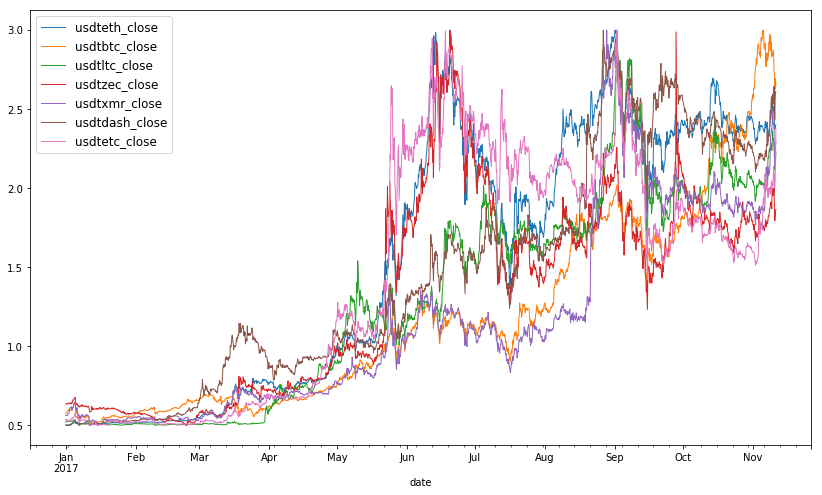

In [9]:
# plot scaled prices
pd.DataFrame(norm_prices,
             columns = price_df.columns.tolist(),
             index = price_df.index).plot(figsize = (14, 8));

In [12]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

In [11]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: invalid value encountered in log
  self.r_log = np.log(self.r)


,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.31172,1.29767,0.481916,35.0199,400,56.585
BCRP,1.25452,1.10468,0.177444,31.8477,246,57.6439
CRP,1.25233,1.08328,-0.0881691,28.9841,372,58.041
EG,1.24163,1.04855,-3.934,28.5344,372,57.2469
BAH,1.2166,0.952527,-0.848224,26.4917,385,57.0483
Anticor,1.01206,0.0594023,-1.345,1.76885,834,50.0994
RMR,0.891672,-0.560371,-2.18612,-16.3523,1488,44.1645
OLMAR,0.870071,-0.677558,-2.39545,-19.3363,1507,44.6286
Kelly,0.804202,-0.882587,-0.969054,-98.7269,1510,55.5099
PAMR,0.723729,-1.61053,-3.82924,-39.9868,1510,36.9292


In [12]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:23

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.18085,0.874469,1.00165,28.9244,109,51.8717
ONS,1.03823,0.174602,-0.0333697,5.7143,343,53.0667
EG,1.03634,0.164834,-3.10227,5.21166,245,52.2667
CRP,1.0336,0.152231,-0.398756,4.6677,144,52
BAH,1.0297,0.13449,-0.717882,4.24623,248,52.8
Anticor,0.917397,-0.41559,-1.32893,-12.7599,360,48.6631
RMR,0.817582,-0.912474,-2.44969,-29.5565,374,43.7333
OLMAR,0.78694,-1.09211,-2.86107,-34.4896,360,42.6667
Kelly,0.658711,-1.90698,-1.9138,-99.9579,374,51.0769
CWMR,0.605083,-2.2552,-5.00676,-59.439,374,36.5333


# (Scaled 6 Hours)

In [7]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (1272, 49)


In [8]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-280,:].copy()
test = norm_prices[-280:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (978, 7)
Test Shape: (280, 7)


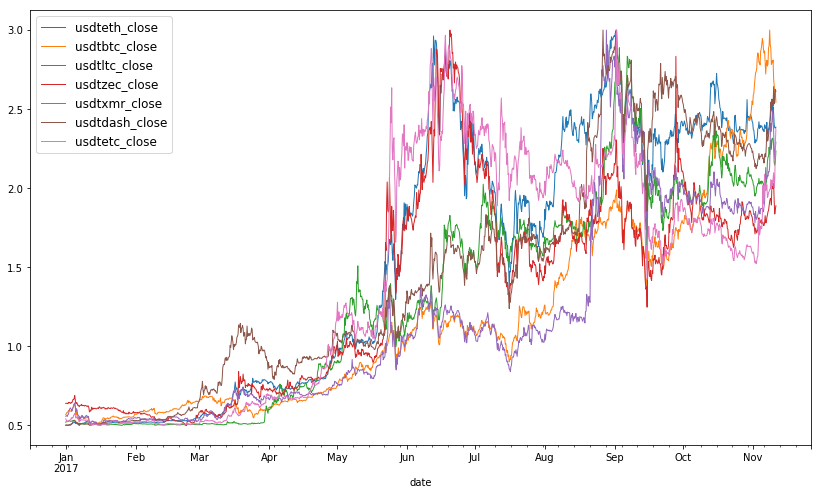

In [9]:
# plot scaled prices
pd.DataFrame(norm_prices,
             columns = price_df.columns.tolist(),
             index = price_df.index).plot(figsize = (14, 8));

In [10]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

Starting: Anticor
Starting: BAH
Starting: BCRP


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:43: UserWarning: scipy.weave is not available in python3, falling back to python version
  warnings.warn('scipy.weave is not available in python3, falling back to python version')
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: 
.ix is deprecated.

Starting: BNN
Starting: CORN
Starting: CRP
Starting: CWMR
Starting: EG
Starting: Kelly


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:239: FutureWarning: pd.rolling_cov is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=50,window=100000000).cov(other=<DataFrame>)
  d[c] = pd.rolling_cov(df[c], df, *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/kelly.py:52: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=50,window=100000000).mean()
  self.M = pd.rolling_mean(X, window=self.window, min_periods=self.min_history)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: divide by zero encountered in log
  self.r_log = np.log(self.r)


Starting: OLMAR
Starting: ONS
Starting: PAMR


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/pamr.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  lam = le / np.linalg.norm(x - x_mean)**2


Starting: RMR


In [11]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: invalid value encountered in log
  self.r_log = np.log(self.r)


,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.46447,1.81673,0.578035,64.3012,267,57.2597
BCRP,1.37995,1.59954,0.274643,58.3577,241,59.6115
CRP,1.37288,1.54276,-0.0866734,53.5261,248,60.4294
EG,1.35708,1.48748,-4.08846,52.8311,248,58.2822
BAH,1.32059,1.35746,-1.01189,49.238,257,58.18
Anticor,1.07519,0.357274,-1.48938,12.6289,472,50.6135
Kelly,0.903163,-0.441464,-0.551489,-91.9638,977,58.0819
OLMAR,0.877925,-0.644097,-2.95319,-21.6012,964,44.4785
CWMR,0.866998,-0.720592,-3.03521,-24.0572,971,40.3885
PAMR,0.857017,-0.780026,-3.10423,-25.774,971,40.3885


In [12]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:23

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.14843,0.766268,1.2507,31.2451,145,55.3571
ONS,1.0034,0.0167579,0.233246,0.696909,277,50.7143
EG,0.990428,-0.0467271,-3.34362,-1.8701,277,51.7857
CRP,0.986403,-0.0667081,-0.44466,-2.60393,277,50.7143
BAH,0.984805,-0.0738479,-0.834177,-2.93903,277,51.7857
Anticor,0.891955,-0.577326,-1.44518,-21.7922,277,47.5
CWMR,0.837349,-0.89282,-1.96252,-35.0575,277,43.9286
PAMR,0.836401,-0.899087,-1.98398,-35.227,277,43.9286
RMR,0.809262,-1.00511,-2.4402,-37.2877,277,46.7857
OLMAR,0.792131,-1.11409,-2.62861,-40.1104,277,46.4286


# (Scaled 12 Hours)

In [6]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (636, 49)


In [7]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-140,:].copy()
test = norm_prices[-140:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (489, 7)
Test Shape: (140, 7)


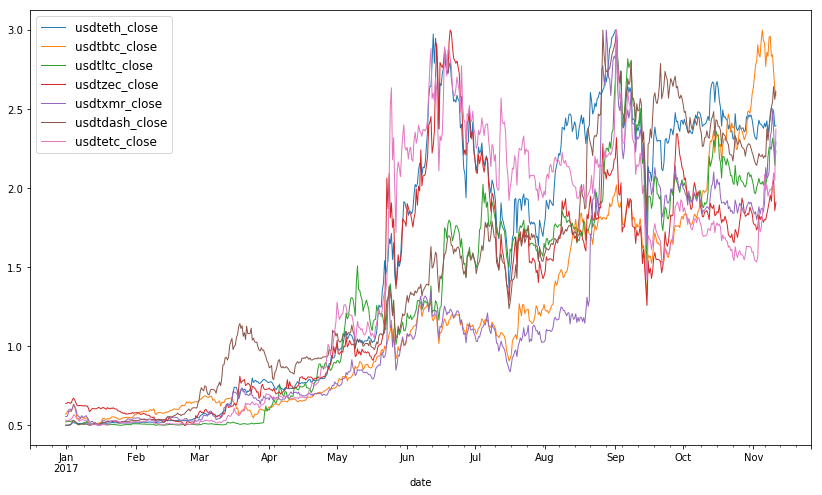

In [8]:
# plot scaled prices
pd.DataFrame(norm_prices,
             columns = price_df.columns.tolist(),
             index = price_df.index).plot(figsize = (14, 8));

In [9]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

Starting: Anticor
Starting: BAH
Starting: BCRP


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:43: UserWarning: scipy.weave is not available in python3, falling back to python version
  warnings.warn('scipy.weave is not available in python3, falling back to python version')
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: 
.ix is deprecated.

Starting: BNN
Starting: CORN
Starting: CRP
Starting: CWMR
Starting: EG
Starting: Kelly


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:239: FutureWarning: pd.rolling_cov is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100000000,min_periods=50).cov(other=<DataFrame>)
  d[c] = pd.rolling_cov(df[c], df, *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/kelly.py:52: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=100000000,min_periods=50).mean()
  self.M = pd.rolling_mean(X, window=self.window, min_periods=self.min_history)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: divide by zero encountered in log
  self.r_log = np.log(self.r)


Starting: OLMAR
Starting: ONS
Starting: PAMR


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/pamr.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  lam = le / np.linalg.norm(x - x_mean)**2


Starting: RMR


In [10]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: invalid value encountered in log
  self.r_log = np.log(self.r)


,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.67846,2.56809,0.808447,169.426,133,59.5092
BCRP,1.55708,2.26896,0.440249,151.49,121,60.7362
CRP,1.54671,2.2,-0.0435859,136.735,123,61.5542
EG,1.52854,2.13062,-4.55769,134.305,123,60.9407
BAH,1.47733,1.95188,-1.4035,123.268,127,60.9407
Anticor,1.13236,0.604824,-1.82289,35.1837,153,49.8978
BNN,1.09815,0.45423,-1.69613,28.4939,277,42.623
Kelly,1.06282,0.288433,0.138371,720.833,488,59.6811
OLMAR,0.984404,-0.0794165,-3.06577,-3.9711,291,48.0573
CORN,0.92804,-0.368004,-2.65385,-19.2891,332,45.6967


In [11]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:23

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.22346,1.11765,1.88541,76.0245,62,55.7143
Anticor,1.007,0.036864,0.256543,2.1193,134,45.7143
ONS,0.998889,-0.0055723,0.336915,-0.31622,137,48.5714
EG,0.9833,-0.0829401,-3.47376,-4.41537,137,47.8571
BAH,0.979909,-0.100241,-0.73814,-5.2758,137,48.5714
CRP,0.977576,-0.111442,-0.666296,-5.80867,137,50
BNN,0.965608,-0.168775,-0.0791901,-6.77574,137,41.2844
OLMAR,0.75583,-1.36329,-3.75586,-56.2471,137,43.5714
RMR,0.73654,-1.49308,-4.03554,-59.9792,137,45
CWMR,0.711685,-1.66044,-4.51882,-63.7634,129,42.8571


# (Scaled 24 Hours)

In [30]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (318, 49)


In [31]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-70,:].copy()
test = norm_prices[-70:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (245, 7)
Test Shape: (70, 7)


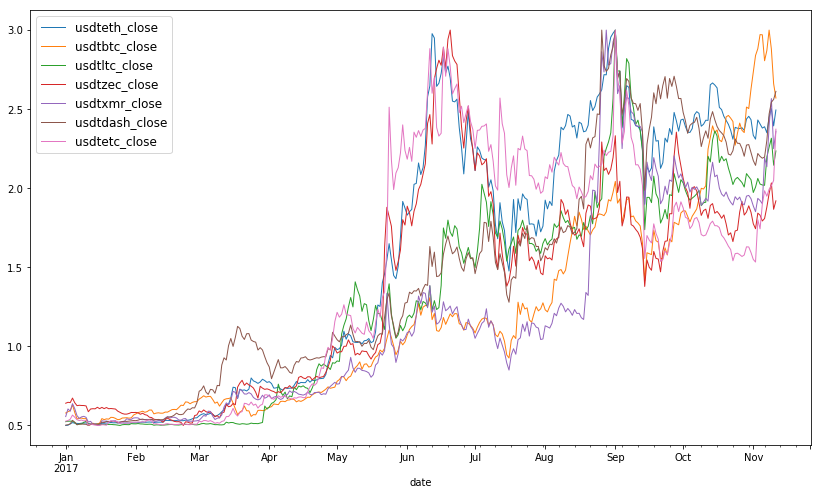

In [32]:
# plot scaled prices
pd.DataFrame(norm_prices,
             columns = price_df.columns.tolist(),
             index = price_df.index).plot(figsize = (14, 8));

In [12]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

In [34]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/result.py:98: RuntimeWarning: invalid value encountered in log
  self.r_log = np.log(self.r)


,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.94077,3.4054,1.30429,611.451,66,60.4082
BCRP,1.80767,3.20365,0.756752,519.479,61,61.6327
CRP,1.77626,3.12788,0.0285665,445.129,62,62.0408
EG,1.74719,2.99866,-5.61149,431.872,62,62.0408
BAH,1.67819,2.78947,-2.15003,378.671,64,61.2245
Anticor,1.52633,2.0297,-0.670974,311.112,55,54.2857
Kelly,1.27434,1.23902,1.02658,2.28376e+06,167,61.0256
BNN,1.24473,1.0563,-1.25711,139.786,81,46.3115
CORN,1.19437,0.952994,-1.8254,110.202,79,42.7984
PAMR,1.14567,0.759275,-2.88977,68.056,136,48.1633


In [35]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:23

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.28979,1.44198,2.35629,176.731,31,50
Anticor,1.04281,0.217976,3.27256,16.9426,65,41.4286
ONS,0.999068,-0.00498934,0.746499,-0.364807,68,41.4286
EG,0.969291,-0.159688,-4.14234,-10.5871,69,41.4286
CRP,0.966053,-0.175261,-0.617662,-11.4616,69,41.4286
BAH,0.960829,-0.200493,-1.13221,-12.9962,69,44.2857
PAMR,0.874229,-0.763488,-1.33413,-45.8932,66,44.2857
CWMR,0.870535,-0.786248,-1.37734,-46.8505,66,44.2857
CORN,0.713443,-1.76614,-1.40447,-63.316,69,33.3333
RMR,0.616887,-2.52217,-6.31397,-85.5414,69,45.7143


## Rerun the 12 & 24 hour periods with USD as an option, to see how it goes :)

# (12 Hours) -- With USD as Asset Option

In [6]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

price_df['usd'] = 1

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-140,:].copy()
test = norm_prices[-140:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

xdf shape: (636, 49)
Train Shape: (489, 8)
Test Shape: (140, 8)


In [9]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    #algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    #algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

Starting: Anticor


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:43: UserWarning: scipy.weave is not available in python3, falling back to python version
  warnings.warn('scipy.weave is not available in python3, falling back to python version')
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:67: RuntimeWarning: invalid value enco

Starting: BAH
Starting: BCRP
Starting: BNN
Starting: CORN
Starting: CWMR


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/cwmr.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  (-b + sqrt(b**2 - 4 * a * c)) / (2. * a),
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/cwmr.py:85: RuntimeWarning: invalid value encountered in double_scalars
  (-b - sqrt(b**2 - 4 * a * c)) / (2. * a))


Starting: EG
Starting: OLMAR
Starting: ONS
Starting: PAMR


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/pamr.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  lam = le / np.linalg.norm(x - x_mean)**2


Starting: RMR


In [11]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.77,3.04372,-1.30425,54.6034,133,58.4867
BCRP,1.55709,2.269,1.16109,151.49,121,60.7362
EG,1.53433,2.14863,-2.59012,112.895,123,60.9407
BAH,1.47334,1.92075,-0.279615,111.619,127,60.9407
BNN,1.09481,0.439147,-1.42218,27.4156,277,42.623
CORN,0.924152,-0.385779,-2.43827,-19.6955,280,45.2869
OLMAR,0.897622,-0.497434,-3.08936,-20.6448,485,43.7358
Anticor,0.885689,-0.620433,-3.26928,-7.29891,481,5.93047
RMR,0.82905,-0.883732,-3.83548,-32.8884,485,42.4107
PAMR,0.76547,-1.29372,-4.52359,-44.5441,482,39.5445


In [12]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:67: RuntimeWarning: invalid value encountered in multiply
  transfer = claim * 0.
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:71: RuntimeWarning: invalid value encountered in true_divide
  transfer[i, :] = weights[t, i] * claim[i, :] / total_claim
/Users/zach-eb

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.22346,1.11765,1.95291,76.0245,62,55.7143
ONS,1.01586,0.0790527,0.489858,4.49012,127,48.5714
EG,0.988829,-0.0552728,-3.72639,-2.59806,137,47.8571
BAH,0.979233,-0.104508,-1.06748,-4.67835,137,48.5714
BNN,0.964022,-0.179013,-0.137572,-6.9438,137,42.0561
Anticor,0.851628,-0.814457,-4.32901,-42.0459,137,18.5714
OLMAR,0.787878,-1.04978,-2.44269,-45.743,137,41.2698
RMR,0.714438,-1.52091,-3.5697,-59.0198,137,42.1053
PAMR,0.61652,-2.06525,-3.69155,-67.78,129,36.1538
CWMR,0.612649,-2.08641,-3.73024,-68.2504,129,36.1538


# (24 Hours) -- With USD as Asset Option

In [6]:
# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

price_df['usd'] = 1

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
norm_prices = scaler.fit_transform(price_df).copy()

train = norm_prices[:-70,:].copy()
test = norm_prices[-70:,:].copy()

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

xdf shape: (318, 49)
Train Shape: (245, 8)
Test Shape: (70, 8)


In [7]:
swensen_allocation = [0.3, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1]

# list all the algos in Universal Portfolio
olps_algos = [
    
    algos.Anticor(),
    algos.BAH(),
    algos.BCRP(),
    algos.BNN(),
    algos.CORN(),
    #algos.CRP(b = swensen_allocation),
    algos.CWMR(),
    algos.EG(),
    #algos.Kelly(),
    algos.OLMAR(),
    algos.ONS(),
    algos.PAMR(),
    algos.RMR(),
    #algos.UP()
]

# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print('Starting:', name)
    olps_train.ix[name,'results'] = alg.run(pd.DataFrame(train))

Starting: Anticor
Starting: BAH
Starting: BCRP


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:43: UserWarning: scipy.weave is not available in python3, falling back to python version
  warnings.warn('scipy.weave is not available in python3, falling back to python version')
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:67: RuntimeWarning: invalid value enco

Starting: BNN
Starting: CORN
Starting: CWMR
Starting: EG


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/cwmr.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  (-b + sqrt(b**2 - 4 * a * c)) / (2. * a),
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/cwmr.py:85: RuntimeWarning: invalid value encountered in double_scalars
  (-b - sqrt(b**2 - 4 * a * c)) / (2. * a))


Starting: OLMAR
Starting: ONS
Starting: PAMR
Starting: RMR


/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/pamr.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  lam = le / np.linalg.norm(x - x_mean)**2


In [8]:
# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,2.1659,4.0362,-1.65939,153.114,66,60.8163
BCRP,1.80767,3.20367,1.79904,519.479,61,61.6327
EG,1.75559,3.01976,-3.25712,340.821,62,62.0408
BAH,1.67171,2.74287,-0.557819,330.592,64,61.2245
Anticor,1.29964,1.26203,-3.69214,26.7705,185,13.4694
BNN,1.24653,1.06123,-0.955697,140.513,81,46.3115
CORN,1.1929,0.866527,-1.23325,108.569,75,42.7984
CWMR,1.1596,0.782375,-2.39748,63.1393,138,44.6721
PAMR,1.15227,0.751476,-2.46357,60.1058,138,45.082
OLMAR,1.02617,0.125442,-3.20894,8.42498,148,44.186


In [9]:
# create the test set dataframe
olps_test = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo = olps_algos

# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(pd.DataFrame(test))

# Let's add fees of 0.25% per transaction (we pay $2.50 for every $1000 of stocks bought or sold).
for k, r in olps_test.results.iteritems():
    r.fee = 0.0025

olps_stats(olps_test)
olps_test[metrics].sort_values('profit', ascending = False)

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:249: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/tools.py:265: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:67: RuntimeWarning: invalid value encountered in multiply
  transfer = claim * 0.
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/universal/algos/anticor.py:71: RuntimeWarning: invalid value encountered in true_divide
  transfer[i, :] = weights[t, i] * claim[i, :] / total_claim
/Users/zach-eb

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.28979,1.44198,2.38183,176.731,31,50
ONS,1.0213,0.113177,0.870516,8.44261,65,41.4286
EG,0.976184,-0.123752,-4.49628,-7.27519,69,41.4286
BAH,0.959657,-0.207532,-1.6562,-11.5456,69,44.2857
Anticor,0.87216,-0.683794,0.548427,-34.8847,69,32.8571
CORN,0.767159,-1.39551,-1.17779,-52.2428,69,38.0952
PAMR,0.679886,-2.01757,-3.98022,-75.7734,69,39.1304
CWMR,0.676521,-2.03097,-4.01755,-76.2101,69,39.1304
RMR,0.667258,-1.94799,-4.37174,-75.6115,69,43.9394
OLMAR,0.643242,-2.11171,-4.82841,-78.7708,69,43.2836
